In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import random
import matplotlib.pyplot as plt
# plot param
%matplotlib inline
plt.rcParams['figure.figsize'] = (22.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

from livelossplot import PlotLosses
from time import sleep

In [2]:
det = True

In [3]:
# parse the controller file
# f = open('../COTONN/dcdc_small/controller.scs', "r")
# f = open('../../COTONN-master/controllers/dcdc_small/controller.scs', "r")
f = open('sequence_int.txt', "r")

lines = []
lines = f.readlines()

# del lines[-1]

In [4]:
len(lines)

100

In [5]:
state_dim = 2
input_dim = 1

In [56]:
# take the state as the train dataset
ltrain_dataset = []
for x in lines:
    ltrain_dataset.append(x.split(' ')[:state_dim])
# del ltrain_dataset[-1] # delete the string #END at the end of the file 

# convert to the numpy array with float32 data type
train_dataset = np.asarray(ltrain_dataset)
train_dataset = train_dataset.astype(np.float32)

upper_limit = train_dataset.shape[0]
num_samples = upper_limit

In [57]:
train_dataset

array([[40., 61.],
       [71., 53.],
       [64., 55.],
       [56., 57.],
       [49., 59.],
       [42., 61.],
       [73., 53.],
       [65., 55.],
       [58., 57.],
       [50., 59.],
       [43., 61.],
       [74., 53.],
       [67., 55.],
       [59., 58.],
       [52., 60.],
       [45., 61.],
       [75., 53.],
       [68., 56.],
       [61., 58.],
       [53., 60.],
       [46., 62.],
       [77., 54.],
       [69., 56.],
       [62., 59.],
       [54., 61.],
       [47., 63.],
       [78., 54.],
       [70., 57.],
       [63., 59.],
       [55., 62.],
       [48., 63.],
       [79., 55.],
       [71., 58.],
       [64., 60.],
       [56., 62.],
       [49., 64.],
       [41., 66.],
       [72., 58.],
       [65., 60.],
       [57., 62.],
       [50., 64.],
       [42., 66.],
       [73., 58.],
       [66., 60.],
       [58., 62.],
       [51., 64.],
       [43., 66.],
       [74., 58.],
       [67., 60.],
       [59., 62.],
       [51., 64.],
       [44., 66.],
       [75.,

In [58]:
# take action/label pair of the state 
# take the action(s) [column 1:-1] / the rest of the integer except the state
ltrain_label = []
for x in lines:
    if det == False:
        ltrain_label.append(x.strip().split()[state_dim:])
    else:
        ltrain_label.append(x.strip().split()[state_dim:state_dim+input_dim])
# del ltrain_label[-1] # delete the string #END at the end of the file  

# convert to numpy array, note that the result is still not in one hot encoding format
train_label = np.asarray(ltrain_label).astype(np.float32)

In [59]:
# define number of samples
num_samples = train_dataset.shape[0]

In [60]:
train_label

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],

In [61]:
if det == False:
    # select to use ND or D case here
    # create now array to be filled by the encoded label
    train_label_int = [[int(i) for i in l] for l in ltrain_label]
    action_setlist = sorted(set(x for l in train_label_int for x in l))
    num_label = len(action_setlist)
    train_label_hot = np.zeros([num_samples, num_label], dtype=np.float32)
    for i,actions in enumerate(train_label_int):
        for action in actions:
            train_label_hot[i, action_setlist.index(action)] = 1
else:
    train_label_hot = train_label[:, None].astype(np.uint8)

In [62]:
len(max(ltrain_label,key=len))

1

In [63]:
upper_limit = train_dataset.shape[0]
upper_limit

100

In [64]:
train_dataset = train_dataset[None,:,:]

In [65]:
def accuracy_softmax(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_multilabel(predictions, labels):
    return (100.0 * np.mean(predictions == labels))

def accuracy_multilabel_softmax(predictions, labels):
    predictions_soft = np.zeros_like(predictions)
    predictions_soft[np.arange(len(predictions)), predictions.argmax(1)] = 1
    return (100.0*np.mean(labels[np.arange(len(labels)), predictions_soft.argmax(1)]))

def accuracy_real_value(predictions, labels):
    return(100.0*np.mean(predictions == labels))

In [132]:
tf.reset_default_graph()
batch_size = 1 # num_samples # (num_samples//20) # 113*6 # num_samples
num_batches = np.ceil(num_samples/batch_size)

# hidden state size
state_size = 1024
# input size (depends on input representation)
input_size = state_dim
# how many time step we want to look back
backprop_length = 50

In [133]:
num_label = train_label.shape[1]

In [134]:
print(batch_size)
print(num_batches)
print(backprop_length)
print(num_label)
print(input_size)

1
100.0
50
1
2


In [135]:
# with tf.device('/device:GPU:0'):
# tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size))
# tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_label))
tf_train_dataset = tf.placeholder(tf.float32, shape=(1, backprop_length, input_size))
tf_train_labels = tf.placeholder(tf.float32, shape=(1, num_label))

In [136]:
tf_train_dataset

<tf.Tensor 'Placeholder:0' shape=(1, 50, 2) dtype=float32>

In [137]:
tf_train_labels

<tf.Tensor 'Placeholder_1:0' shape=(1, 1) dtype=float32>

In [138]:
inputs_series = tf.unstack(tf_train_dataset, axis = 1)
inputs_series

[<tf.Tensor 'unstack:0' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:1' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:2' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:3' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:4' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:5' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:6' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:7' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:8' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:9' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:10' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:11' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:12' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:13' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:14' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:15' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:16' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:17' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'unstack:18' shape=(1, 2) 

In [139]:
Wout = tf.Variable(np.random.rand(state_size, num_label),dtype=tf.float32)
bout = tf.Variable(np.random.rand(1,num_label), dtype=tf.float32)

In [140]:
from tensorflow.contrib import rnn 

In [141]:
cell_state = tf.placeholder(tf.float32, [1, state_size])
hidden_state = tf.placeholder(tf.float32, [1, state_size])
init_state = tf.nn.rnn_cell.LSTMStateTuple(cell_state, hidden_state)

In [142]:
cell = rnn.BasicLSTMCell(state_size)
states_series, current_state = rnn.static_rnn(cell, inputs_series, init_state)

In [143]:
states_series

[<tf.Tensor 'rnn/basic_lstm_cell/Mul_2:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_5:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_8:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_11:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_14:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_17:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_20:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_23:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_26:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_29:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_32:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_35:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_cell/Mul_38:0' shape=(1, 1024) dtype=float32>,
 <tf.Tensor 'rnn/basic_lstm_

In [144]:
current_state

LSTMStateTuple(c=<tf.Tensor 'rnn/basic_lstm_cell/Add_99:0' shape=(1, 1024) dtype=float32>, h=<tf.Tensor 'rnn/basic_lstm_cell/Mul_149:0' shape=(1, 1024) dtype=float32>)

In [145]:
logits = tf.matmul(states_series[-1], Wout) + bout

In [146]:
logits

<tf.Tensor 'add:0' shape=(1, 1) dtype=float32>

In [147]:
predictions = tf.round(logits)

In [148]:
losses = tf.losses.mean_squared_error(labels = tf_train_labels, predictions=logits)
total_loss = tf.reduce_mean(losses)
# train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.0015).minimize(total_loss)

In [149]:
train_dataset.shape

(1, 100, 2)

In [150]:
state_size

1024

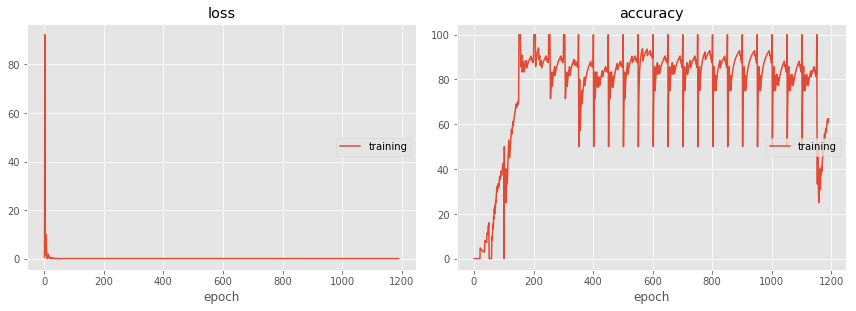

Epoch:    24, Loss: 0.000131, Accuracy: 62.50%
40


In [ ]:
loss_history = []
acc_history = []
liveplot = PlotLosses()

acc = 0
acc_cum = 0
acc_temp = 0
epoch_idx = 0
loss_disp_true = True
loss_avg = 0.0
old_loss_avg = 0.0
loss_cum = 0.0
need_one_more_iteration = True
batch_limit = 0

early_stop_loss_counter = 0
not_early_stop = True

with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    while (((acc < 100) or need_one_more_iteration) and not_early_stop):
        
        if (acc >= 100):
            need_one_more_iteration = False
        else:
            need_one_more_iteration = True
            
        epoch_idx += 1
        acc_cum = 0
        
        _current_cell_state = np.zeros((batch_size, state_size))
        _current_hidden_state = np.zeros((batch_size, state_size))
        
        for step in range(int(num_batches-backprop_length)):
            offset = step # (step * batch_size)
            print(offset)
            # loss_disp_true = True
            # if (num_samples-1 > (offset + backprop_length)): # batch_size:
            batch_limit = offset + backprop_length # batch_size
                # print("false")
            # else:
                # batch_limit = offset + backprop_length
                # loss_disp_true = True
                # print("true")
                # print(offset)
            
            # _current_state = np.zeros((num_layers, 2, batch_limit-offset, state_size))
            
            batch_data = train_dataset[:, offset:(batch_limit), :]
            batch_labels = train_label[None, batch_limit-1]

            l , _train_step, _current_state, _predictions, = session.run(
                [total_loss, train_step, current_state, predictions],
                feed_dict={
                    tf_train_dataset: batch_data,
                    tf_train_labels: batch_labels,
                    # init_state : _current_state
                    cell_state: _current_cell_state,
                    hidden_state: _current_hidden_state
                })
            
            _current_cell_state, _current_hidden_state = _current_state
            
            # writer.add_summary(added_summary)
            # acc_temp =  accuracy_multilabel_softmax(_predictions, batch_labels)
            acc_temp =  accuracy_real_value(_predictions, batch_labels)
            acc_cum += acc_temp
            acc = acc_cum/(step+1)
            loss_cum += l
            if loss_disp_true:
                # loss_disp_true = False
                loss_avg = loss_cum/num_batches
                loss_cum = 0
                loss_history.append(loss_avg)
                acc_history.append(acc)
                liveplot.update({
                    'accuracy': acc,
                    'loss': loss_avg,
                })
                liveplot.draw()
                print("Epoch:{0:6d}, Loss: {1:8.6f}, Accuracy:{2:6.2f}%".format(epoch_idx, loss_avg, acc))
                
                if loss_avg == old_loss_avg:
                    print('stagnan')
                    early_stop_loss_counter += 1
                    if early_stop_loss_counter == 100:
                        not_early_stop = False    
                old_loss_avg = loss_avg
       
"""
    # Do for the test batch
    acc = 0
    acc_cum = 0
    for step in range(int(num_batches)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) #  % (train_label_hot.shape[0] - batch_size)
        
        if num_samples > offset + batch_size:
            batch_limit = offset + batch_size
        else:
            batch_limit = num_samples
            loss_disp_true = True

        # _current_cell_state = (np.zeros((batch_limit-offset, state_size)))
        # _current_hidden_state = (np.zeros((batch_limit-offset, state_size)))
        _current_state = np.zeros((num_layers, 2, batch_limit-offset, state_size))
        # offset = np.random.randint(num_samples - batch_size , size = 1)[0]
        # Generate a minibatch.
        batch_data = train_dataset_reform[offset:(batch_limit), :]
        batch_labels = train_label_hot[offset:(batch_limit), :]

        l, _current_state, _predictions, = session.run(
            [total_loss, current_state, predictions],
            feed_dict={
                tf_train_dataset: batch_data,
                tf_train_labels: batch_labels,
                init_state : _current_state
            })

        # writer.add_summary(added_summary)
        acc_temp =  accuracy_multilabel_softmax(_predictions, batch_labels)
        acc_cum += acc_temp
        acc = acc_cum/(step+1)
        
        print("batch_limit {0:6d} Training Acc: {1:8.2f} {2:8.2f} {3:8.2f}%".format(batch_limit, acc_temp, acc_cum, acc))

    print(acc)
"""

In [86]:
batch_limit

3

In [87]:
batch_data

array([[[71., 53.],
        [64., 55.]]], dtype=float32)

In [88]:
acc_history[-10:]

[95.6043956043956,
 95.65217391304348,
 95.6989247311828,
 95.74468085106383,
 95.78947368421052,
 95.83333333333333,
 95.87628865979381,
 95.91836734693878,
 100.0,
 100.0]

In [89]:
batch_labels

array([[1.]], dtype=float32)

In [91]:
_predictions

array([[1.]], dtype=float32)

In [ ]:
hidden = 'LSTM'+str(state_size)

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
plt.style.use('ggplot')
plt.plot(loss_history)
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig(f.name[:-4]+hidden+'_loss_nd.png', dpi = 200)

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
plt.style.use('ggplot')
plt.plot(acc_history)
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig(f.name[:-4]+hidden+'_acc_nd.png', dpi = 200)

In [ ]:
lh_array = np.array(loss_history)[:, np.newaxis]

In [ ]:
ah_array = np.array(acc_history)[:, np.newaxis]

In [ ]:
ei_array = np.arange(epoch_idx, dtype=object)[:, np.newaxis]

In [ ]:
training_history = np.concatenate((ei_array, lh_array, ah_array), axis = 1)

In [ ]:
np.savetxt(f.name[:-4]+hidden+'_nd.csv', training_history, delimiter=",", fmt = "%d,""%2.6f,""%2.2f")